In [135]:
import numpy as np

from scipy.optimize import minimize
from matplotlib import pyplot as plt
from instruments.instruments import Equity

In [251]:
start = "2012-12-28"
end = "2022-07-11"
interval = "wk"
stock = Equity(ric="XOM", currency="USD", start_date=start,
                end_date=end, interval=interval)
data = stock.log_return_history

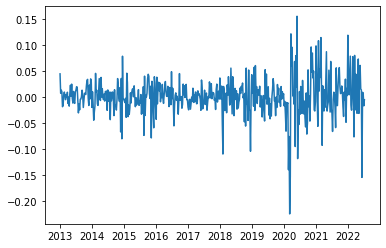

In [252]:
plt.plot(data)
plt.show()

In [253]:
# Initial Solution
long_run_vol = np.std(data)
long_run_vol
start_vol = np.std(data[:20])

In [254]:
def generate_volatility(params, data):
    result = np.zeros(len(data))
    for i in range(1, len(data)):
        if i == 1:
            result[i] = start_vol ** 2
        else:
            result[i] = long_run_vol**2 + np.exp(-np.exp(-params[0])) * (
                np.exp(-np.exp(-params[1])) * result[i-1]
                + (1-np.exp(-np.exp(-params[1])))*data[i-1]**2 - long_run_vol**2
            )
    return result

In [255]:
def cost_function(params, data):
    vol_est = generate_volatility(params=params, data=data)
    log_loss = 0
    for i in range(1, len(data)):
        log_loss +=  (np.log(vol_est[i]) + data[i] ** 2 / vol_est[i])

    return log_loss

In [256]:
alpha = 0.01
beta = 0.80

In [257]:
mu_corr = alpha + beta
mu_ewma = beta / (mu_corr)

In [258]:
z_corr = np.log(-1/np.log(mu_corr))
z_ewma = np.log(-1/np.log(mu_ewma))

In [259]:
init_params = [z_corr, z_ewma]

In [267]:
sol = minimize(cost_function, init_params, args=data)
sol

      fun: -3002.5116460287327
 hess_inv: array([[0.05216266, 0.00659131],
       [0.00659131, 0.00105938]])
      jac: array([0.00000000e+00, 9.15527344e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 127
      nit: 8
     njev: 40
   status: 2
  success: False
        x: array([3.54344731, 1.61930851])

In [261]:
sol.x

array([3.54344731, 1.61930851])

In [262]:
def _redo_parameters(sol):
    mu_corr = np.exp(-np.exp(-sol[0]))
    mu_ewma = np.exp(-np.exp(-sol[1]))

    beta = mu_corr * mu_ewma    
    alpha = mu_corr - beta

    return [alpha, beta]

In [263]:
_redo_parameters(sol.x)

[0.17453914498659262, 0.7969613688554309]

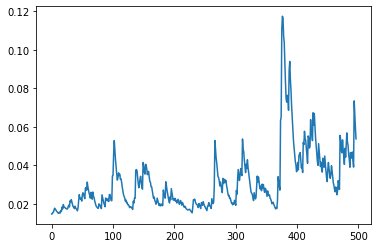

In [264]:
plt.plot(np.sqrt(generate_volatility(sol.x, data))[1:])

plt.show()